In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, minmax_scale, robust_scale
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data into a DataFrame
df = pd.read_csv('100_Sales.csv')

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          100 non-null    object 
 1   Country         100 non-null    object 
 2   Item_Type       100 non-null    object 
 3   Sales_Channel   100 non-null    object 
 4   Order_Priority  100 non-null    object 
 5   Ship_Date       100 non-null    object 
 6   Unit_Cost       100 non-null    float64
 7   Total_Revenue   100 non-null    float64
 8   Total_Profit    100 non-null    float64
 9   Unnamed: 9      0 non-null      float64
 10  Unnamed: 10     0 non-null      float64
dtypes: float64(5), object(6)
memory usage: 8.7+ KB


In [138]:
df.describe()

,Unit_Cost,Total_Revenue,Total_Profit,Unnamed: 9,Unnamed: 10
count,100.000000,1.000000e+02,1.000000e+02,0.0,0.0
mean,191.048000,1.373488e+06,4.416820e+05,NaN,NaN
std,188.208181,1.460029e+06,4.385379e+05,NaN,NaN
min,6.920000,4.870260e+03,1.258020e+03,NaN,NaN
25%,35.840000,2.687212e+05,1.214436e+05,NaN,NaN
50%,107.275000,7.523144e+05,2.907680e+05,NaN,NaN
75%,263.330000,2.212045e+06,6.358288e+05,NaN,NaN
max,524.960000,5.997055e+06,1.719922e+06,NaN,NaN


In [139]:
df.head()

,Region,Country,Item_Type,Sales_Channel,Order_Priority,Ship_Date,Unit_Cost,Total_Revenue,Total_Profit,Unnamed: 9,Unnamed: 10
0,Australia and Oceania,Tuvalu,Baby Food,Offline,H,27/06/2010,159.42,2533654.00,951410.50,NaN,NaN
1,Central America and the Caribbean,Grenada,Cereal,Online,C,15/09/2012,117.11,576782.80,248406.36,NaN,NaN
2,Europe,Russia,Office Supplies,Offline,L,05/08/2014,524.96,1158502.59,224598.75,NaN,NaN
3,Sub_Saharan Africa,Sao Tome and Principe,Fruits,Online,C,07/05/2014,6.92,75591.66,19525.82,NaN,NaN
4,Sub_Saharan Africa,Rwanda,Office Supplies,Offline,L,02/06/2013,524.96,3296425.02,639077.50,NaN,NaN


In [140]:
df.dropna(axis = 1, inplace = True)

In [141]:
df.isnull().sum()
# Replace '/' with '-' in 'Ship_Date' if necessary
df['Ship_Date'] = df['Ship_Date'].str.replace('/', '-')

# Convert 'Ship_Date' to datetime with the correct format
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], format='%d-%m-%Y', errors='coerce')

# Check for any parsing errors
if df['Ship_Date'].isnull().any():
    print("Some dates couldn't be parsed. Here are the problematic entries:")
    print(df[df['Ship_Date'].isnull()])
    # Drop rows with missing 'Ship_Date'
    df.dropna(subset=['Ship_Date'], inplace=True)

# Extract date features
df['Ship_Year'] = df['Ship_Date'].dt.year
df['Ship_Month'] = df['Ship_Date'].dt.month
df['Ship_Day'] = df['Ship_Date'].dt.day

# Drop 'Ship_Date' as it's no longer needed
df.drop('Ship_Date', axis=1, inplace=True)

# Ensure date features are numerical
df[['Ship_Year', 'Ship_Month', 'Ship_Day']] = df[['Ship_Year', 'Ship_Month', 'Ship_Day']].astype(int)

In [142]:
df.isnull().sum()

Region            0
Country           0
Item_Type         0
Sales_Channel     0
Order_Priority    0
Unit_Cost         0
Total_Revenue     0
Total_Profit      0
Ship_Year         0
Ship_Month        0
Ship_Day          0
dtype: int64

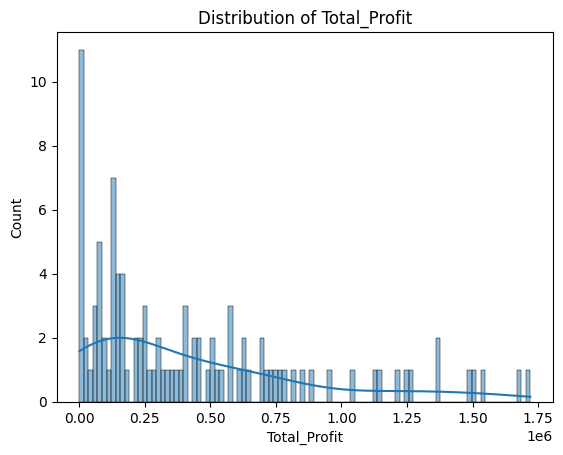

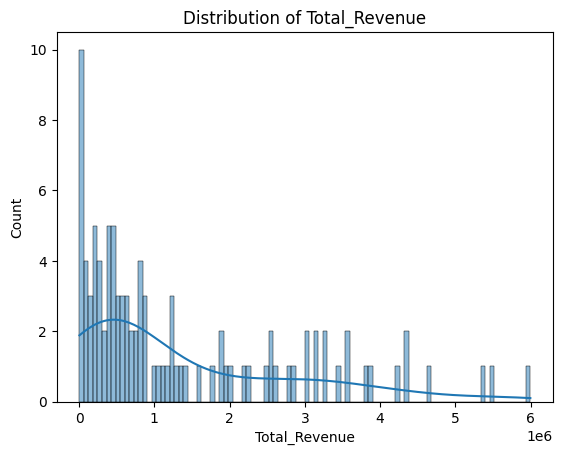

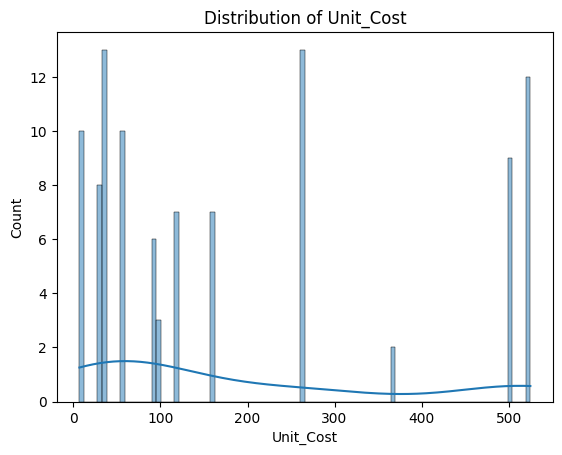

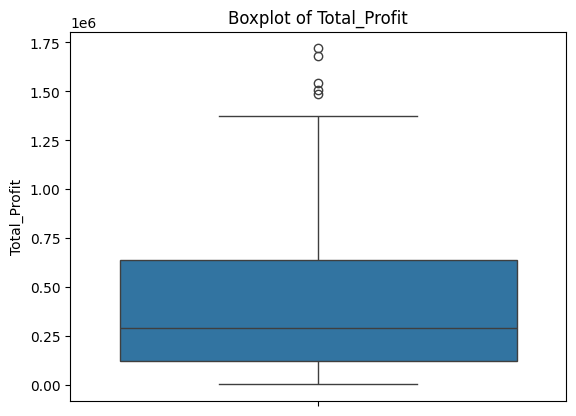

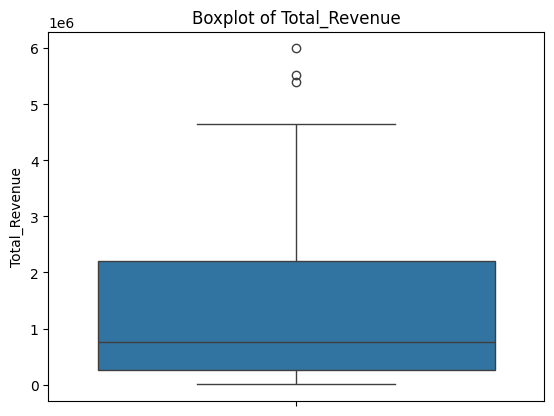

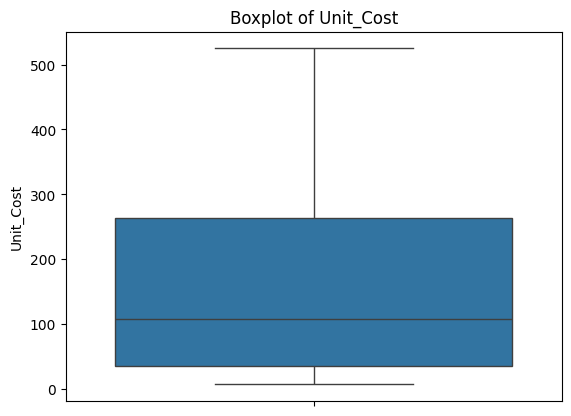

In [143]:
#Plotting box plots and historagrams to figure out the outliers and collinearity too
sns.histplot(df['Total_Profit'], bins=100, kde=True)
plt.title('Distribution of Total_Profit')
plt.show()

sns.histplot(df['Total_Revenue'], bins=100, kde=True)
plt.title('Distribution of Total_Revenue')
plt.show()

sns.histplot(df['Unit_Cost'], bins=100, kde=True)
plt.title('Distribution of Unit_Cost')
plt.show()

sns.boxplot(df['Total_Profit'])
plt.title('Boxplot of Total_Profit')
plt.show()

sns.boxplot(df['Total_Revenue'])
plt.title('Boxplot of Total_Revenue')
plt.show()

sns.boxplot(df['Unit_Cost'])
plt.title('Boxplot of Unit_Cost')
plt.show()

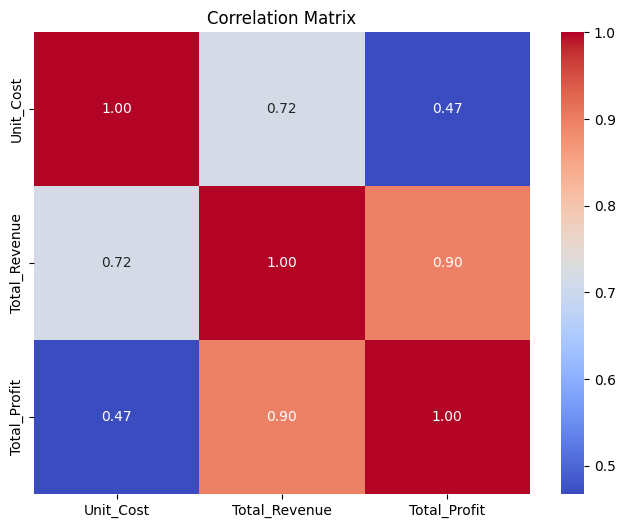

Variance Inflation Factors (VIF):
         Feature        VIF
0          const   2.759755
1      Unit_Cost   3.023022
2  Total_Revenue  12.130779
3   Total_Profit   7.571103


In [144]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def plot_correlation_and_vif(data, column_names):
    """
    This function plots the correlation matrix and calculates VIF for the given columns.
    
    Parameters:
    - data: pandas DataFrame, the dataset containing the columns.
    - column_names: list of strings, the names of the columns to analyze.
    
    Returns:
    - None, but it will plot the correlation matrix and print the VIF values.
    """
    
    # Select the columns from the data
    X = data[column_names]
    
    # 1. Plot the Correlation Matrix
    correlation_matrix = X.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title('Correlation Matrix')
    plt.show()
    
    # 2. Calculate the VIF values
    X_with_const = add_constant(X)  # Adding constant for intercept
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    
    # Print VIF values
    print("Variance Inflation Factors (VIF):")
    print(vif_data)

column_names = ['Unit_Cost', 'Total_Revenue', 'Total_Profit']  # Replace with your columns
plot_correlation_and_vif(df, column_names)

In [145]:
df.nunique()

Region              7
Country            76
Item_Type          12
Sales_Channel       2
Order_Priority      4
Unit_Cost          12
Total_Revenue     100
Total_Profit      100
Ship_Year           8
Ship_Month         12
Ship_Day           30
dtype: int64

In [146]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# Drop the 'Country' column as it's not being used
df = df.drop(columns=['Country'])

# Define the ColumnTransformer to apply OneHotEncoder to categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('nom', OneHotEncoder(drop='first'), ['Region', 'Sales_Channel']),
        # 'Order_Priority' will be handled separately using OrdinalEncoder
    ],
    remainder='passthrough'  # Leave the other columns unchanged
)

# Apply the transformation to the dataset (OneHotEncoder will be applied to 'Region' and 'Sales_Channel')
transformed_data = column_transformer.fit_transform(df)

# Apply OrdinalEncoder to 'Order_Priority' column separately
# Define the custom priority order: Critical > High > Medium > Low
priority_order = ['L', 'M', 'H', 'C']  # Low < Medium < High < Critical
ordinal_encoder = OrdinalEncoder(categories=[priority_order])

# Apply OrdinalEncoder to the 'Order_Priority' column
df['Order_Priority'] = ordinal_encoder.fit_transform(df[['Order_Priority']])

# Convert the transformed data back into a DataFrame
# The column names are generated by the ColumnTransformer for the OneHotEncoded columns
df_transformed = pd.DataFrame(transformed_data, columns=column_transformer.get_feature_names_out())

# Now, include the 'Order_Priority' column that was label encoded
df_transformed['Order_Priority'] = df['Order_Priority']

# Clean up column names by removing the 'remainder__' prefix for readability
df_transformed.columns = [col.replace('remainder__', '') for col in df_transformed.columns]

# Display the transformed dataframe
df = df_transformed
df = pd.get_dummies(df, columns=['Item_Type'], drop_first=True)
df


,nom__Region_Australia and Oceania,nom__Region_Central America and the Caribbean,nom__Region_Europe,nom__Region_Middle East and North Africa,nom__Region_North America,nom__Region_Sub_Saharan Africa,nom__Sales_Channel_Online,Order_Priority,Unit_Cost,Total_Revenue,...,Item_Type_Cereal,Item_Type_Clothes,Item_Type_Cosmetics,Item_Type_Fruits,Item_Type_Household,Item_Type_Meat,Item_Type_Office Supplies,Item_Type_Personal Care,Item_Type_Snacks,Item_Type_Vegetables
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,H,159.42,2533654.0,...,False,False,False,False,False,False,False,False,False,False
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,C,117.11,576782.8,...,True,False,False,False,False,False,False,False,False,False
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,L,524.96,1158502.59,...,False,False,False,False,False,False,True,False,False,False
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,C,6.92,75591.66,...,False,False,False,True,False,False,False,False,False,False
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,L,524.96,3296425.02,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,1.0,1.0,M,35.84,97040.64,...,False,True,False,False,False,False,False,False,False,False
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,6.92,58471.11,...,False,False,False,True,False,False,False,False,False,False
97,0.0,0.0,0.0,0.0,0.0,1.0,0.0,C,90.93,228779.1,...,False,False,False,False,False,False,False,False,False,True
98,0.0,0.0,0.0,0.0,1.0,0.0,0.0,M,56.67,471336.91,...,False,False,False,False,False,False,False,True,False,False


In [147]:
# List of numerical columns (assuming they are in the DataFrame)
numerical_columns = ['Unit_Cost', 'Total_Revenue', 'Total_Profit']

# Function to cap outliers based on IQR
def cap_outliers_iqr(df, cols):
    for col in cols:
        # Calculate Q1, Q3, and IQR for the column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the values to the bounds
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

# Apply the function to cap outliers for the numerical columns
df = cap_outliers_iqr(df, numerical_columns)

# Display the DataFrame to check if outliers are capped
df.head()

,nom__Region_Australia and Oceania,nom__Region_Central America and the Caribbean,nom__Region_Europe,nom__Region_Middle East and North Africa,nom__Region_North America,nom__Region_Sub_Saharan Africa,nom__Sales_Channel_Online,Order_Priority,Unit_Cost,Total_Revenue,...,Item_Type_Cereal,Item_Type_Clothes,Item_Type_Cosmetics,Item_Type_Fruits,Item_Type_Household,Item_Type_Meat,Item_Type_Office Supplies,Item_Type_Personal Care,Item_Type_Snacks,Item_Type_Vegetables
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,H,159.42,2533654.0,...,False,False,False,False,False,False,False,False,False,False
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,C,117.11,576782.8,...,True,False,False,False,False,False,False,False,False,False
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,L,524.96,1158502.59,...,False,False,False,False,False,False,True,False,False,False
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,C,6.92,75591.66,...,False,False,False,True,False,False,False,False,False,False
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,L,524.96,3296425.02,...,False,False,False,False,False,False,True,False,False,False


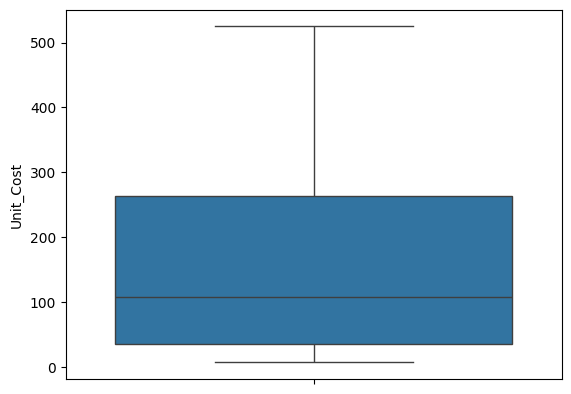

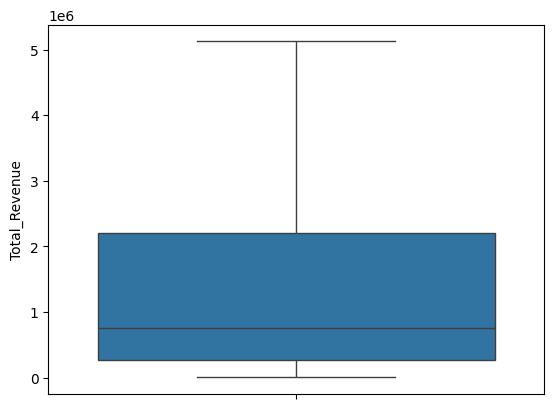

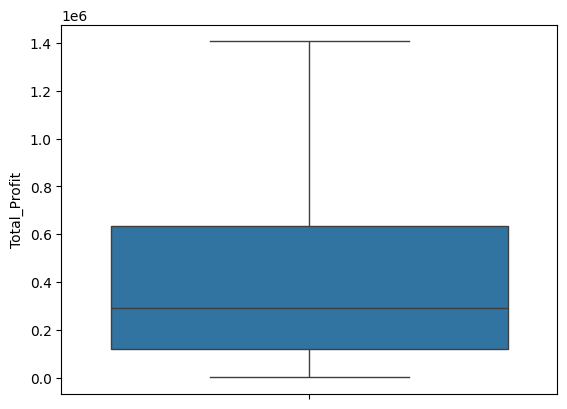

In [148]:
for plot in numerical_columns:
    sns.boxplot(df[plot])
    plt.show()

In [149]:
print(df.columns)

Index(['nom__Region_Australia and Oceania',
       'nom__Region_Central America and the Caribbean', 'nom__Region_Europe',
       'nom__Region_Middle East and North Africa', 'nom__Region_North America',
       'nom__Region_Sub_Saharan Africa', 'nom__Sales_Channel_Online',
       'Order_Priority', 'Unit_Cost', 'Total_Revenue', 'Total_Profit',
       'Ship_Year', 'Ship_Month', 'Ship_Day', 'Order_Priority',
       'Item_Type_Beverages', 'Item_Type_Cereal', 'Item_Type_Clothes',
       'Item_Type_Cosmetics', 'Item_Type_Fruits', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Office Supplies',
       'Item_Type_Personal Care', 'Item_Type_Snacks', 'Item_Type_Vegetables'],
      dtype='object')


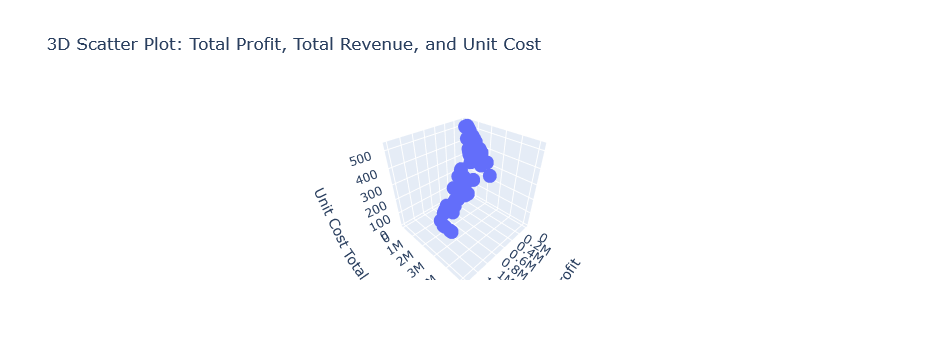

In [150]:
import plotly.express as px
fig = px.scatter_3d(df, x='Total_Profit', y='Total_Revenue', z='Unit_Cost', 
                    title="3D Scatter Plot: Total Profit, Total Revenue, and Unit Cost",
                    labels={'Total_Profit': 'Total Profit', 'Total_Revenue': 'Total Revenue', 'Unit_Cost': 'Unit Cost'})

# Show the plot
fig.show()

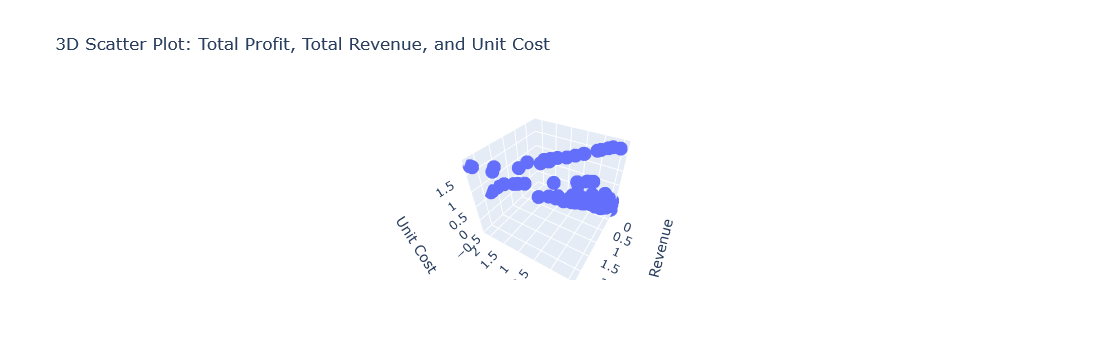

In [151]:
df[numerical_columns] = robust_scale(df[numerical_columns])

fig = px.scatter_3d(df, x='Total_Profit', y='Total_Revenue', z='Unit_Cost', 
                    title="3D Scatter Plot: Total Profit, Total Revenue, and Unit Cost",
                    labels={'Total_Profit': 'Total Profit', 'Total_Revenue': 'Total Revenue', 'Unit_Cost': 'Unit Cost'})
fig.show()

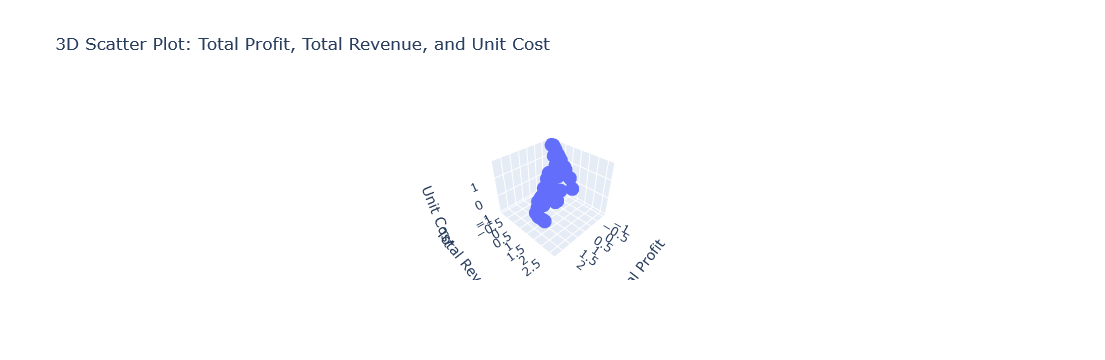

In [134]:
from sklearn.preprocessing import StandardScaler
#Standardization
scaler = StandardScaler()
df[['Total_Profit', 'Total_Revenue', 'Unit_Cost']] = scaler.fit_transform(df[['Total_Profit', 'Total_Revenue', 'Unit_Cost']])

fig = px.scatter_3d(df, x='Total_Profit', y='Total_Revenue', z='Unit_Cost', 
                    title="3D Scatter Plot: Total Profit, Total Revenue, and Unit Cost",
                    labels={'Total_Profit': 'Total Profit', 'Total_Revenue': 'Total Revenue', 'Unit_Cost': 'Unit Cost'})
fig.show()

In [152]:
# Step 1: Lasso Regression and Model Evaluation

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming 'Total_Revenue' is your target variable and the rest are features
X = df.drop(columns=['Total_Revenue', 'Order_Priority'])  # Remove target and redundant columns
y = df['Total_Revenue']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Lasso regression model
lasso = Lasso(alpha=0.1)  # You can adjust alpha for regularization strength
lasso.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

#Standardization works best here


Mean Absolute Error (MAE): 0.21842209254963807
Mean Squared Error (MSE): 0.0779516129755658
Root Mean Squared Error (RMSE): 0.2791981607668034
